## REFORMAT DATASET ----------------------------------------------------------------
Reformatting the layout of the overall dataset in terms of column information, tupled statsitical data, and identifying the null values.

In [15]:
#LIBRARY IMPORTS
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import preprocessing as prep


In [2]:
#COMBINING ALL THE STORM DETAILS FROM THE YEARS 2007 - 2023

NaturalDisaster_Data = pd.read_csv("./Storm Dataset/StormDetails2007.csv")

#Iterate through all the Storm Details years and combine datasets to create one single large one
for year in range(2007, 2023):
    currentYear_Data = pd.read_csv(f"./Storm Dataset/StormDetails{year}.csv")
    #NaturalDisaster_Data.append(currentYear_Data, ignore_index = True)
    NaturalDisaster_Data = pd.concat([NaturalDisaster_Data, currentYear_Data])



In [3]:
NaturalDisaster_Data.columns.values

array(['BEGIN_YEARMONTH', 'BEGIN_DAY', 'BEGIN_TIME', 'END_YEARMONTH',
       'END_DAY', 'END_TIME', 'EPISODE_ID', 'EVENT_ID', 'STATE',
       'STATE_FIPS', 'YEAR', 'MONTH_NAME', 'EVENT_TYPE', 'CZ_TYPE',
       'CZ_FIPS', 'CZ_NAME', 'WFO', 'BEGIN_DATE_TIME', 'CZ_TIMEZONE',
       'END_DATE_TIME', 'INJURIES_DIRECT', 'INJURIES_INDIRECT',
       'DEATHS_DIRECT', 'DEATHS_INDIRECT', 'DAMAGE_PROPERTY',
       'DAMAGE_CROPS', 'SOURCE', 'MAGNITUDE', 'MAGNITUDE_TYPE',
       'FLOOD_CAUSE', 'CATEGORY', 'TOR_F_SCALE', 'TOR_LENGTH',
       'TOR_WIDTH', 'TOR_OTHER_WFO', 'TOR_OTHER_CZ_STATE',
       'TOR_OTHER_CZ_FIPS', 'TOR_OTHER_CZ_NAME', 'BEGIN_RANGE',
       'BEGIN_AZIMUTH', 'BEGIN_LOCATION', 'END_RANGE', 'END_AZIMUTH',
       'END_LOCATION', 'BEGIN_LAT', 'BEGIN_LON', 'END_LAT', 'END_LON',
       'EPISODE_NARRATIVE', 'EVENT_NARRATIVE', 'DATA_SOURCE'],
      dtype=object)

In [4]:
#Natural Disaster Dataset Size = 23,580
NaturalDisaster_Data = NaturalDisaster_Data.loc[NaturalDisaster_Data['EVENT_TYPE'] == "Tornado"]

## DATA PREPROCESSING ----------------------------------------------------------------
Cleaning up the data in terms of normalization, feature selection, and ordinally categorizing the the target variable.

In [102]:
temp_df = NaturalDisaster_Data.copy(deep=True)

In [103]:
temp_df = temp_df.drop(columns=['BEGIN_DAY','END_YEARMONTH','END_DAY','STATE_FIPS','YEAR','MONTH_NAME',
                                                          'EVENT_TYPE','CZ_FIPS','END_DATE_TIME', 'FLOOD_CAUSE','CATEGORY',
                                                          'BEGIN_AZIMUTH','END_AZIMUTH','TOR_OTHER_WFO','TOR_OTHER_CZ_STATE',
                                                          'TOR_OTHER_CZ_NAME','MAGNITUDE_TYPE', 'EVENT_NARRATIVE', 'EPISODE_NARRATIVE',
                                                          'BEGIN_DATE_TIME', 'TOR_OTHER_CZ_FIPS', 'BEGIN_LON', 'END_LON', 'MAGNITUDE', 'CZ_TYPE'])

In [104]:
temp_df['TOR_F_SCALE'].describe()

count     23580
unique       10
top         EF0
freq      11730
Name: TOR_F_SCALE, dtype: object

In [105]:
temp_df = temp_df.dropna(subset = ['TOR_F_SCALE'])
len(temp_df)

23580

In [106]:
#Transform Damage Property and Damage To Crops Data to 0 and convert into numerical dollar values
temp_df["DAMAGE_PROPERTY"] = temp_df["DAMAGE_PROPERTY"].fillna(0.0)
temp_df["DAMAGE_CROPS"] = temp_df["DAMAGE_CROPS"].fillna(0.0)

def transform_DamageCost(damage_data, damage_column):
    damage = pd.DataFrame(damage_data)
    for index,row in damage.iterrows():
        if type(row[damage_column]) != type(0.0):
            cost = row[damage_column]
            if cost[-1:] == 'B':
                row[damage_column] = float(cost[:-1])*1000000000
            elif cost[-1:] == 'M':
                row[damage_column] = float(cost[:-1])*1000000
            elif cost[-1:] == 'K':
                row[damage_column] = float(cost[:-1])*1000

    return damage

temp_df["DAMAGE_PROPERTY"] = transform_DamageCost(temp_df["DAMAGE_PROPERTY"], "DAMAGE_PROPERTY")
temp_df["DAMAGE_CROPS"] = transform_DamageCost(temp_df["DAMAGE_CROPS"], "DAMAGE_CROPS")

In [107]:
#Transforming the TOR_F_Scale into numerical, ordinal data that takes into account the magnitude of the tornadoes
tornado_scale = pd.DataFrame(temp_df["TOR_F_SCALE"])
for index, row in tornado_scale.iterrows():
    scale = row["TOR_F_SCALE"]
    if scale[-1:] == '0' or scale[-1:] == 'U':
        row["TOR_F_SCALE"] = 0
    elif scale[-1:] == '1':
        row["TOR_F_SCALE"] = 1
    elif scale[-1:] == '2':
        row["TOR_F_SCALE"] = 2
    elif scale[-1:] == '3':
        row["TOR_F_SCALE"] = 3
    elif scale[-1:] == '4':
        row["TOR_F_SCALE"] = 4
    elif scale[-1:] == '5':
        row["TOR_F_SCALE"] = 5
temp_df["TOR_F_SCALE"] = tornado_scale

In [109]:
#Transforming label data into encoded, numerical data types
labelEn = prep.LabelEncoder()
temp_df['STATE'] = labelEn.fit_transform(temp_df['STATE'])
temp_df['CZ_NAME'] = labelEn.fit_transform(temp_df['CZ_NAME'])
temp_df['WFO'] = labelEn.fit_transform(temp_df['WFO'])
temp_df['CZ_TIMEZONE'] = labelEn.fit_transform(temp_df['CZ_TIMEZONE'])
temp_df['SOURCE'] = labelEn.fit_transform(temp_df['SOURCE'])
temp_df['BEGIN_LOCATION'] = labelEn.fit_transform(temp_df['BEGIN_LOCATION'])
temp_df['END_LOCATION'] = labelEn.fit_transform(temp_df['END_LOCATION'])
temp_df['DATA_SOURCE'] = labelEn.fit_transform(temp_df['DATA_SOURCE'])

In [110]:
temp_df['DAMAGE_PROPERTY'] = temp_df['DAMAGE_PROPERTY'].astype('float') 
temp_df['DAMAGE_CROPS'] = temp_df['DAMAGE_CROPS'].astype('float')
temp_df['TOR_F_SCALE'] = temp_df['TOR_F_SCALE'].astype('int')

In [111]:
#Filling all missing data with zeroes
temp_df["BEGIN_RANGE"] = temp_df["BEGIN_RANGE"].fillna(0.0)
temp_df["END_RANGE"] = temp_df["END_RANGE"].fillna(0.0)
temp_df["BEGIN_LAT"] = temp_df["BEGIN_LAT"].fillna(0.0)
temp_df["END_LAT"] = temp_df["END_LAT"].fillna(0.0)


## DISPLAYING DATAFRAME VISUALS ------------------------------------------------------

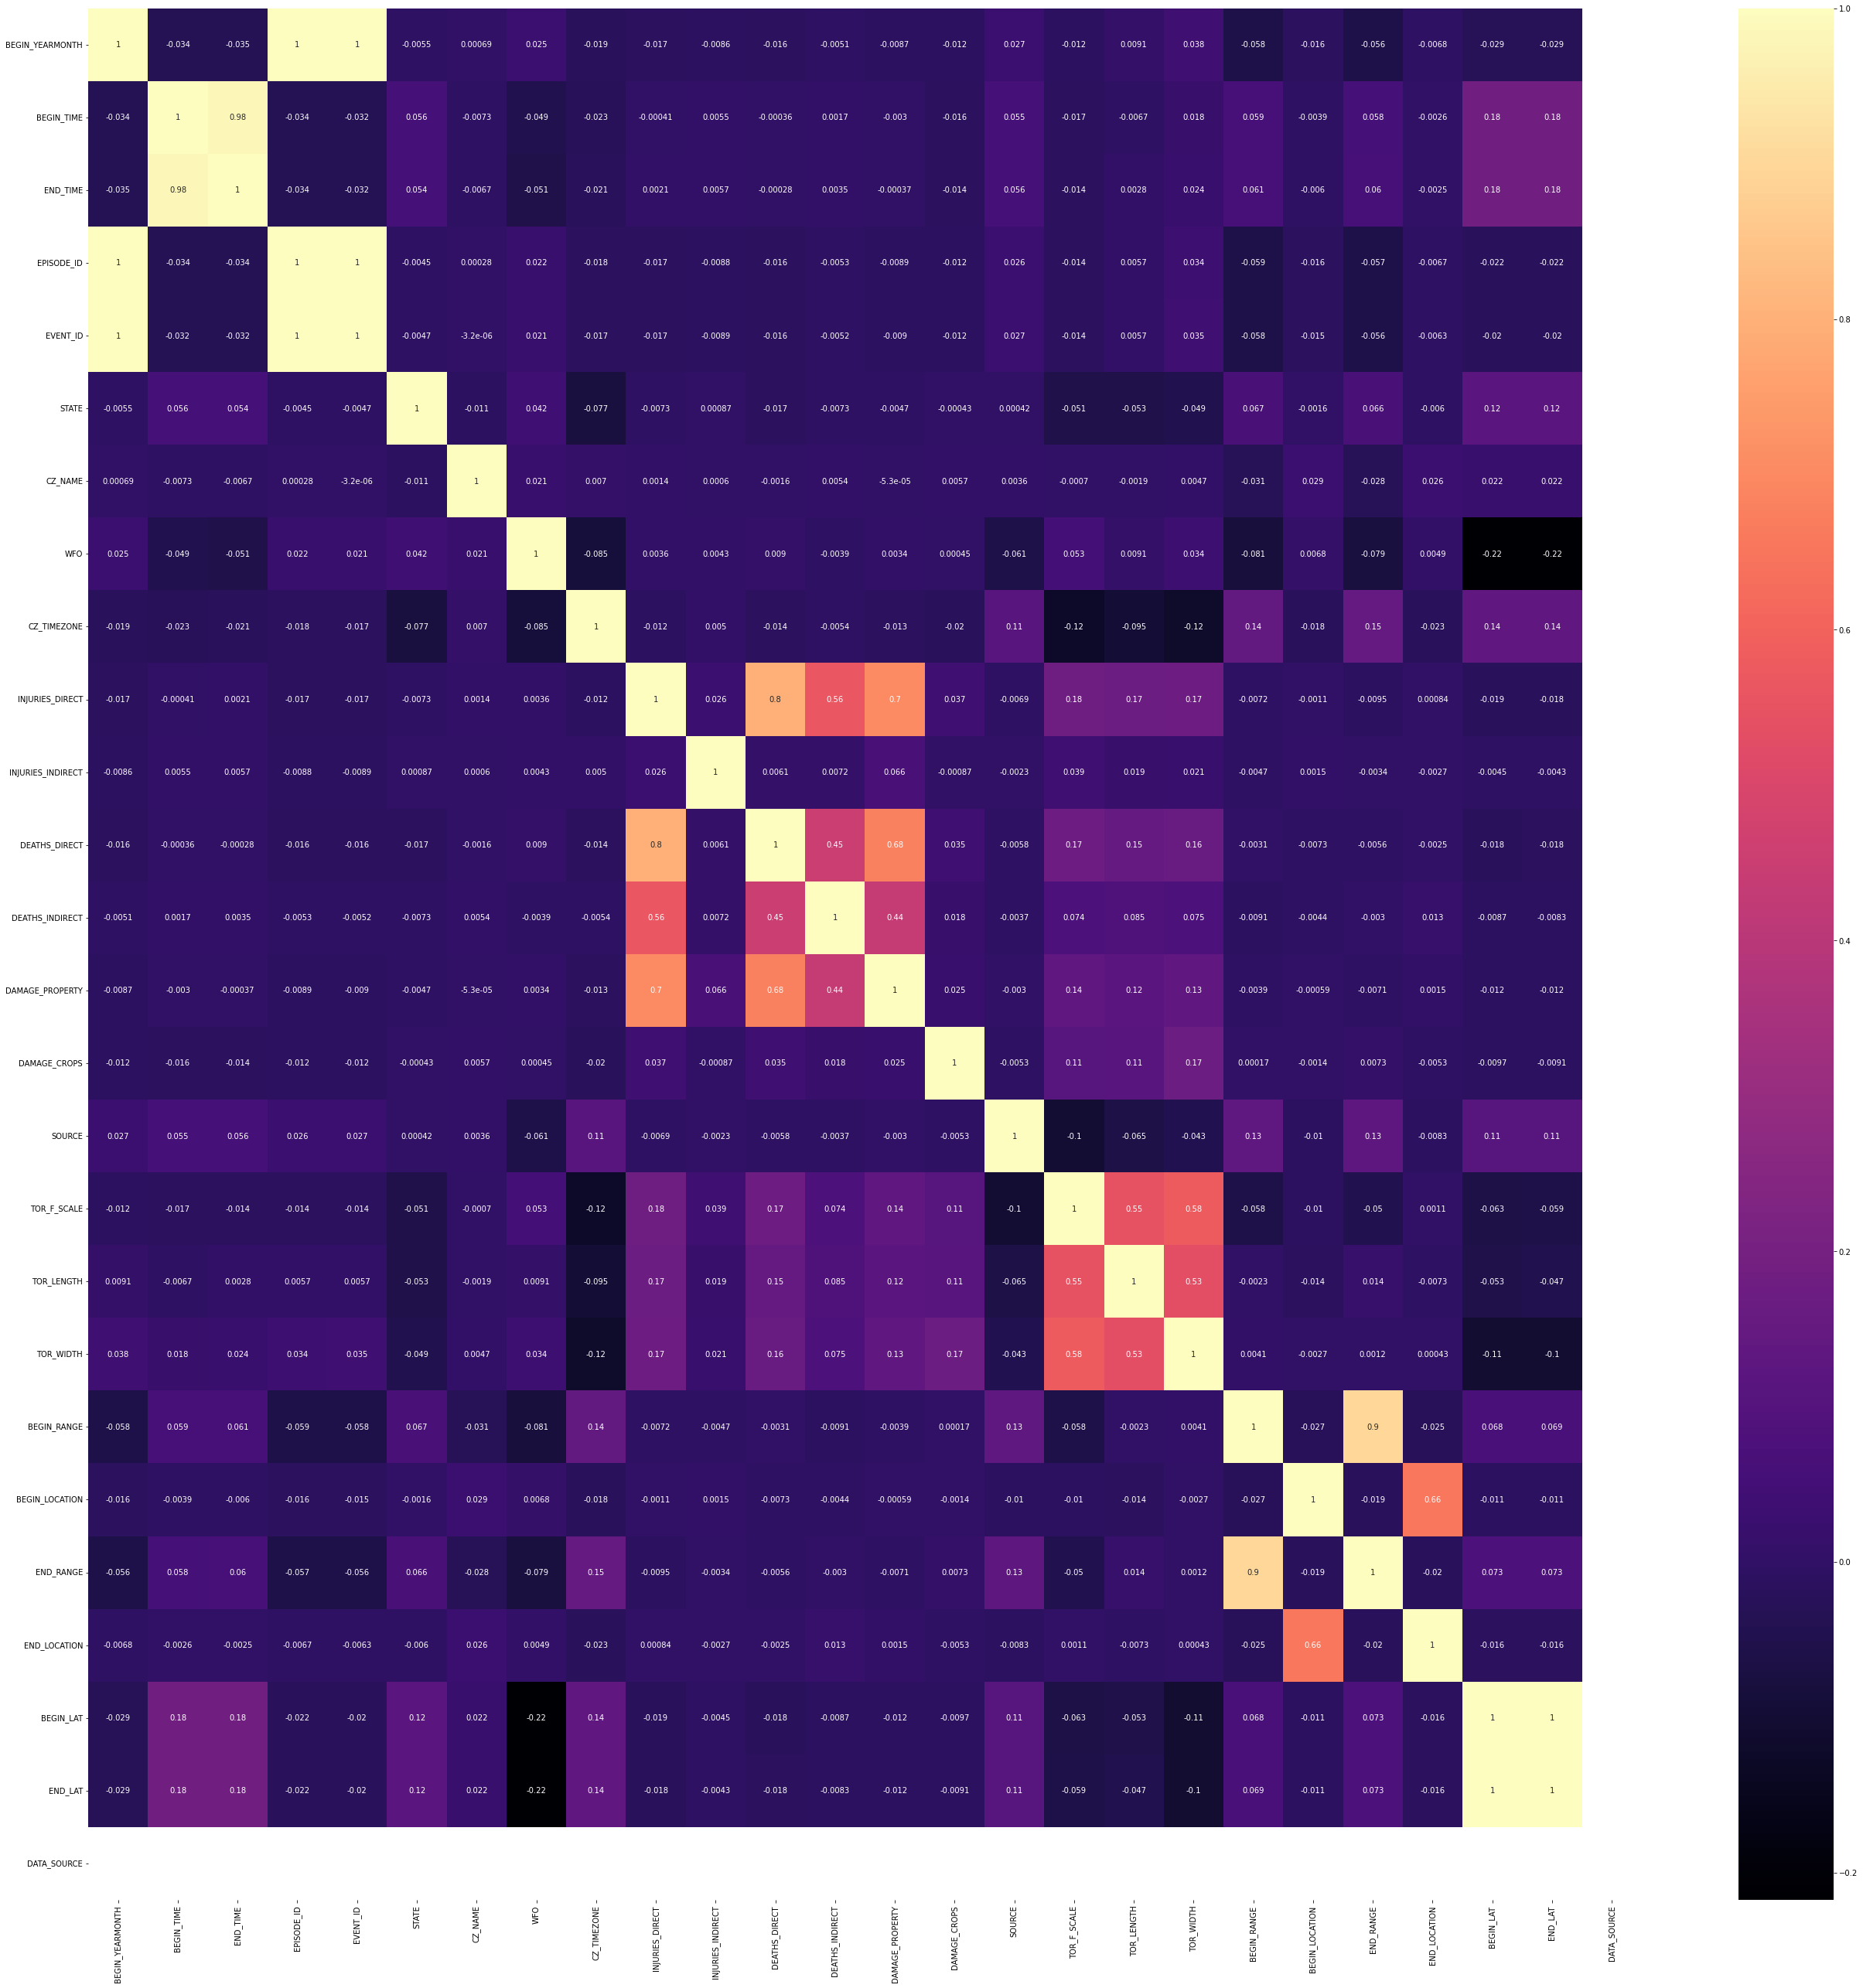

In [112]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt



X = temp_df.iloc[:,0:37]
y = temp_df['TOR_F_SCALE']
#get correlations of each features in dataset
corrmat = temp_df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(45,45))
#plot heat map
g=sns.heatmap(temp_df[top_corr_features].corr(),annot=True,cmap="magma")

In [113]:

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

#Columns
X = temp_df.iloc[:, 0:30]
y = temp_df['TOR_F_SCALE']

#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

              Specs         Score
13  DAMAGE_PROPERTY  2.106358e+12
14     DAMAGE_CROPS  1.363631e+09
4          EVENT_ID  2.430188e+07
3        EPISODE_ID  4.013504e+06
18        TOR_WIDTH  3.970168e+06
9   INJURIES_DIRECT  6.723610e+05
11    DEATHS_DIRECT  1.436125e+05
17       TOR_LENGTH  4.157433e+04
16      TOR_F_SCALE  2.449341e+04
20   BEGIN_LOCATION  2.040446e+04


In [114]:
classifier_DisasterDf = temp_df[['DAMAGE_PROPERTY', 'DAMAGE_CROPS', 'EVENT_ID', 'EPISODE_ID', 'TOR_WIDTH', 'INJURIES_DIRECT','DEATHS_DIRECT','TOR_LENGTH',
                                'TOR_F_SCALE','INJURIES_INDIRECT','DEATHS_INDIRECT','BEGIN_LOCATION','END_LOCATION']]
classifier_DisasterDf.head()

,DAMAGE_PROPERTY,DAMAGE_CROPS,EVENT_ID,EPISODE_ID,TOR_WIDTH,INJURIES_DIRECT,DEATHS_DIRECT,TOR_LENGTH,TOR_F_SCALE,INJURIES_INDIRECT,DEATHS_INDIRECT,BEGIN_LOCATION,END_LOCATION
166,20000.0,0.0,45063,7822,30.0,0,0,0.55,0,0,0,10216,10240
263,0.0,0.0,22128,3951,300.0,0,0,1.50,2,0,0,804,794
558,0.0,0.0,22131,3951,50.0,0,0,0.20,1,0,0,10229,10251
656,180000.0,0.0,64108,11659,150.0,0,0,3.47,1,0,0,6434,7173
736,20000.0,0.0,25721,4525,30.0,0,0,0.15,0,0,0,9959,9991


## DATA CLASSIFIER ------------------------------------------------

In [115]:
# Data Processing
import pandas as pd
import numpy as np

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

In [121]:
# Split the data into features (X) and target (y)
X = classifier_DisasterDf.drop('TOR_F_SCALE', axis=1)
y = classifier_DisasterDf['TOR_F_SCALE']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7309160305343512


In [122]:
#Confusion Matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred))
cm

,0,1,2,3,4,5
0,2141,385,1,0,0,0
1,428,1097,82,3,0,0
2,21,221,162,12,0,0
3,2,40,48,42,4,0
4,0,2,6,12,4,0
5,0,0,1,0,1,1


In [123]:
#EVALUATING THE CLASSIFIER
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
	
print('Precision: %.3f' % precision_score(y_test, y_pred, average='micro'))
print('Recall: %.3f' % recall_score(y_test, y_pred, average = 'micro'))
print('F1 Score: %.3f' % f1_score(y_test, y_pred, average = 'micro'))

Precision: 0.731
Recall: 0.731
F1 Score: 0.731


## NORMALIZATION --------------------------------------------------------

In [ ]:
##SIDE NOTE:
# Normalize the data in order to test a Gaussian Classifier to determine the magnitue of the tornadoes and 
#Also implement a distance based classifier to determine the amount of damage that will be incurred from the tornadoes based on magnitude, intensity, size etc.
# To do this, we'll have to perform normalization to remove the skewed distribition and any effects caused by outliers 

In [126]:
#normalizing dataframe
temp_df.apply(lambda iterator: ((iterator - iterator.mean())/iterator.std()).round(2))


,BEGIN_YEARMONTH,BEGIN_TIME,END_TIME,EPISODE_ID,EVENT_ID,STATE,CZ_NAME,WFO,CZ_TIMEZONE,INJURIES_DIRECT,...,TOR_F_SCALE,TOR_LENGTH,TOR_WIDTH,BEGIN_RANGE,BEGIN_LOCATION,END_RANGE,END_LOCATION,BEGIN_LAT,END_LAT,DATA_SOURCE
166,-1.44,-0.69,-0.70,-1.43,-1.43,-1.06,0.37,0.07,0.58,-0.06,...,-0.78,-0.61,-0.53,-0.36,1.29,-0.36,1.29,-2.56,-2.57,NaN
263,-1.44,-1.72,-1.72,-1.50,-1.50,-1.06,-1.62,0.01,0.58,-0.06,...,1.68,-0.38,0.39,-0.61,-1.49,-0.62,-1.51,-1.35,-1.35,NaN
558,-1.44,-1.16,-1.16,-1.50,-1.50,-1.06,1.21,0.01,0.58,-0.06,...,0.45,-0.69,-0.46,-0.36,1.29,-0.36,1.29,-1.52,-1.52,NaN
656,-1.43,0.26,0.25,-1.36,-1.37,-0.01,1.30,-0.03,-0.53,-0.06,...,0.45,0.09,-0.12,-0.36,0.17,-0.62,0.38,-0.75,-0.75,NaN
736,-1.44,1.30,1.30,-1.49,-1.49,0.76,-1.14,-0.15,0.58,-0.06,...,-0.78,-0.70,-0.53,-0.10,1.21,-0.11,1.22,0.60,0.60,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68627,1.65,1.14,1.13,1.73,1.74,0.83,-1.55,-1.64,-0.53,-0.06,...,-0.78,-0.45,-0.46,-0.61,-1.52,-0.36,-1.54,-0.09,-0.09,NaN
68676,1.65,-0.00,-0.00,1.73,1.74,-1.62,1.30,-1.49,-0.53,-0.06,...,0.45,0.31,0.14,0.15,1.13,-0.11,1.14,-0.97,-0.96,NaN
68680,1.65,0.07,0.06,1.72,1.74,-0.01,0.68,0.16,-0.53,-0.06,...,-0.78,-0.46,-0.46,-0.61,1.13,-0.62,1.14,-1.31,-1.31,NaN
68681,1.65,0.44,0.44,1.72,1.74,-0.01,-0.38,0.16,-0.53,-0.06,...,0.45,-0.19,-0.29,-0.61,-1.47,-0.36,-1.73,-1.38,-1.38,NaN
